[Link to Github Repository](https://github.com/RoryAJames/CIND-820/tree/3253a4fe43331c026f5bbf49636ffb9ea60b0e50)

In [60]:
#Import packages

import numpy as np
import pandas as pd
import geopandas as gpd
import requests
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
from scipy.stats import norm, skew
import warnings
warnings.filterwarnings('ignore')

## Working With Building Permits Data

In [61]:
url = 'https://opendata.vancouver.ca/api/v2/catalog/datasets/issued-building-permits/exports/geojson?limit=-1&offset=0&timezone=UTC'
data = requests.get(url)
permits_df = gpd.GeoDataFrame().from_features(data.json())
permits_df = permits_df.set_crs('EPSG:4326').to_crs('EPSG:3857') # Set all geopandas dataframes to the same coordinate reference system

In [62]:
permits_df.head()

,geometry,permitnumber,permitnumbercreateddate,issuedate,permitelapseddays,projectvalue,typeofwork,address,projectdescription,permitcategory,...,applicantaddress,propertyuse,specificusecategory,buildingcontractor,buildingcontractoraddress,issueyear,geolocalarea,yearmonth,geo_point_2d,geom
0,POINT (-13699502.789 6321885.570),BP-2021-03669,2021-07-15,2021-07-26,11,0.0,Salvage and Abatement,"1938 VENABLES STREET, Vancouver, BC V5L 2H8",Low Density Housing - Salvage and Abatement - ...,None,...,"13564 67 Ave\r\nSurrey, BC V3W2B8",[Dwelling Uses],[Single Detached House],SOURCE ONE EXCAVATING LTD,None,2021,Grandview-Woodland,2021-07,"{'lon': -123.0647274, 'lat': 49.2763653}",NaN
1,POINT (-13697280.073 6315668.465),BP-2016-04179,2016-12-06,2017-10-04,302,15000.0,Demolition / Deconstruction,"4950 MOSS STREET, Vancouver, BC V5R 3T4",Low Density Housing - Demolition / Deconstruct...,None,...,"17055 - 60th Avenue\r\nSurrey, BC V3S 1T3",[Dwelling Uses],[Duplex],SOURCE ONE EXCAVATING LTD,None,2017,Renfrew-Collingwood,2017-10,"{'lon': -123.0447604, 'lat': 49.2399152}",NaN
2,POINT (-13705506.060 6321760.620),BP-2017-04112,2017-08-04,2017-09-05,32,15000.0,Addition / Alteration,"1011 CAMBIE STREET, Vancouver, BC V6B 5L7",Field Review - Addition / Alteration - 1011 Ca...,Renovation - Commercial/ Mixed Use - Lower Com...,...,"105 - 2544 Douglas Rd\r\nBurnaby, BC V5C 5W7",[Service Uses],[School - Arts or Self-Improvement],Gibraltar Holdings,None,2017,Downtown,2017-09,"{'lon': -123.1186557, 'lat': 49.275633}",NaN
3,POINT (-13705804.808 6323067.917),BP-2017-01959,2017-04-13,2017-04-26,13,18000.0,Addition / Alteration,"777 HORNBY STREET, Vancouver, BC V6Z 1S4",Field Review - Addition / Alteration - Unit #9...,Renovation - Commercial/ Mixed Use - Lower Com...,...,"105 - 2544 Douglas Rd\r\nBurnaby, BC V5C 5W7",[Office Uses],[General Office],Gibraltar Holdings,None,2017,Downtown,2017-04,"{'lon': -123.1213394, 'lat': 49.2832942}",NaN
4,POINT (-13705168.584 6323326.253),BP-2017-02645,2017-05-16,2017-06-12,27,15000.0,Addition / Alteration,"750 W PENDER STREET, Vancouver, BC V6C 2T7",Field Review - Addition / Alteration - #720-7t...,Renovation - Commercial/ Mixed Use - Lower Com...,...,"105 - 2544 Douglas Rd\r\nBurnaby, BC V5C 5W7",[Office Uses],[General Office],Gibraltar Holdings,None,2017,Downtown,2017-06,"{'lon': -123.1156241, 'lat': 49.284808}",NaN


### Data Cleaning & Preparation

In [63]:
#Check data types

permits_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 33987 entries, 0 to 33986
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   geometry                   33643 non-null  geometry
 1   permitnumber               33987 non-null  object  
 2   permitnumbercreateddate    33987 non-null  object  
 3   issuedate                  33987 non-null  object  
 4   permitelapseddays          33987 non-null  int64   
 5   projectvalue               33987 non-null  float64 
 6   typeofwork                 33987 non-null  object  
 7   address                    33922 non-null  object  
 8   projectdescription         33987 non-null  object  
 9   permitcategory             19386 non-null  object  
 10  applicant                  33987 non-null  object  
 11  applicantaddress           33901 non-null  object  
 12  propertyuse                33982 non-null  object  
 13  specificusecategory    

In [64]:
#Remove unnecessary columns

cols_to_keep = ['geometry','projectvalue','typeofwork','propertyuse','issueyear','geolocalarea']

permits_df = permits_df[cols_to_keep]

permits_df.head()

,geometry,projectvalue,typeofwork,propertyuse,issueyear,geolocalarea
0,POINT (-13699502.789 6321885.570),0.0,Salvage and Abatement,[Dwelling Uses],2021,Grandview-Woodland
1,POINT (-13697280.073 6315668.465),15000.0,Demolition / Deconstruction,[Dwelling Uses],2017,Renfrew-Collingwood
2,POINT (-13705506.060 6321760.620),15000.0,Addition / Alteration,[Service Uses],2017,Downtown
3,POINT (-13705804.808 6323067.917),18000.0,Addition / Alteration,[Office Uses],2017,Downtown
4,POINT (-13705168.584 6323326.253),15000.0,Addition / Alteration,[Office Uses],2017,Downtown


In [65]:
#Rename columns to more appropriate names

new_columns = {'projectvalue':'ProjectValue',
               'typeofwork':'WorkType',
               'propertyuse':'PropertyUse',
               'issueyear':'Year',
               'geolocalarea':'Area'
               }

permits_df.rename(columns=new_columns, inplace=True)

In [66]:
permits_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 33987 entries, 0 to 33986
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   geometry      33643 non-null  geometry
 1   ProjectValue  33987 non-null  float64 
 2   WorkType      33987 non-null  object  
 3   PropertyUse   33982 non-null  object  
 4   Year          33987 non-null  object  
 5   Area          33636 non-null  object  
dtypes: float64(1), geometry(1), object(4)
memory usage: 1.6+ MB


In [67]:
#Convert year column to integer

permits_df['Year'] = permits_df['Year'].astype(str).astype(int)
permits_df.dtypes

geometry        geometry
ProjectValue     float64
WorkType          object
PropertyUse       object
Year               int32
Area              object
dtype: object

In [68]:
permits_df.head()

,geometry,ProjectValue,WorkType,PropertyUse,Year,Area
0,POINT (-13699502.789 6321885.570),0.0,Salvage and Abatement,[Dwelling Uses],2021,Grandview-Woodland
1,POINT (-13697280.073 6315668.465),15000.0,Demolition / Deconstruction,[Dwelling Uses],2017,Renfrew-Collingwood
2,POINT (-13705506.060 6321760.620),15000.0,Addition / Alteration,[Service Uses],2017,Downtown
3,POINT (-13705804.808 6323067.917),18000.0,Addition / Alteration,[Office Uses],2017,Downtown
4,POINT (-13705168.584 6323326.253),15000.0,Addition / Alteration,[Office Uses],2017,Downtown


#### Data Cleaning & Preparation - Property Use

In [69]:
#Check value counts for property use

permits_df.PropertyUse.value_counts()

[Dwelling Uses]                                                                             23877
[Office Uses]                                                                                4218
[Retail Uses]                                                                                1686
[Service Uses]                                                                               1337
[Institutional Uses]                                                                          668
                                                                                            ...  
[Office Uses, Parking Uses, Service Uses, Wholesale Uses]                                       1
[Cultural/Recreational Uses, Institutional Uses, Office Uses, Parking Uses, Retail Uses]        1
[Cultural/Recreational Uses, Dwelling Uses, Retail Uses]                                        1
[Cultural/Recreational Uses, Parking Uses]                                                      1
[Institutional Uses,

In [70]:
# Create a number of uses column by counting the number of items in the property use column which is a list of values

permits_df["NumberOfUses"] = permits_df.PropertyUse.str.len()

#Remove the rows where the number of uses is blank

permits_df = permits_df[permits_df['NumberOfUses'].notna()]

#Convert number of uses to an integer

permits_df["NumberOfUses"] = permits_df["NumberOfUses"].astype(int)

In [71]:
permits_df.NumberOfUses.value_counts()

1    32989
2      734
3      186
4       57
5       16
Name: NumberOfUses, dtype: int64

In [72]:
#Create a new revised property use column that converts the original column from a list of values into a string of values

permits_df['PropertyUseRevised'] = permits_df.PropertyUse.apply(lambda x: ', '.join([str(i) for i in x]))

permits_df.head()

,geometry,ProjectValue,WorkType,PropertyUse,Year,Area,NumberOfUses,PropertyUseRevised
0,POINT (-13699502.789 6321885.570),0.0,Salvage and Abatement,[Dwelling Uses],2021,Grandview-Woodland,1,Dwelling Uses
1,POINT (-13697280.073 6315668.465),15000.0,Demolition / Deconstruction,[Dwelling Uses],2017,Renfrew-Collingwood,1,Dwelling Uses
2,POINT (-13705506.060 6321760.620),15000.0,Addition / Alteration,[Service Uses],2017,Downtown,1,Service Uses
3,POINT (-13705804.808 6323067.917),18000.0,Addition / Alteration,[Office Uses],2017,Downtown,1,Office Uses
4,POINT (-13705168.584 6323326.253),15000.0,Addition / Alteration,[Office Uses],2017,Downtown,1,Office Uses


In [73]:
#Change property use revised column base on the number of uses column. If the number of uses is greater than 1, change the value of property use revised to mixed use, otherwise keep it the same.

permits_df['PropertyUseRevised'] = np.where(permits_df.NumberOfUses > 1, 'Mixed Uses', permits_df.PropertyUseRevised)

In [74]:
permits_df.PropertyUseRevised.value_counts()

Dwelling Uses                      23877
Office Uses                         4218
Retail Uses                         1686
Service Uses                        1337
Mixed Uses                           993
Institutional Uses                   668
Cultural/Recreational Uses           542
Manufacturing Uses                   250
Wholesale Uses                       126
Transportation and Storage Uses      112
Parking Uses                          93
Utility and Communication Uses        56
Live-Work Uses                        19
Agricultural Uses                      3
Mural                                  1
Deposition or Extraction Uses          1
Name: PropertyUseRevised, dtype: int64

In [75]:
#Remove number of uses and original property use columns now that they are redundant

permits_df = permits_df[['geometry','ProjectValue','WorkType','Year','Area','PropertyUseRevised']]

permits_df.head()

,geometry,ProjectValue,WorkType,Year,Area,PropertyUseRevised
0,POINT (-13699502.789 6321885.570),0.0,Salvage and Abatement,2021,Grandview-Woodland,Dwelling Uses
1,POINT (-13697280.073 6315668.465),15000.0,Demolition / Deconstruction,2017,Renfrew-Collingwood,Dwelling Uses
2,POINT (-13705506.060 6321760.620),15000.0,Addition / Alteration,2017,Downtown,Service Uses
3,POINT (-13705804.808 6323067.917),18000.0,Addition / Alteration,2017,Downtown,Office Uses
4,POINT (-13705168.584 6323326.253),15000.0,Addition / Alteration,2017,Downtown,Office Uses


#### Data Cleaning & Preparation - Work Type

In [76]:
permits_df.WorkType.value_counts()

Addition / Alteration                   16485
New Building                             7752
Salvage and Abatement                    4901
Demolition / Deconstruction              4479
Temporary Building / Structure            320
Outdoor Uses (No Buildings Proposed)       45
Name: WorkType, dtype: int64

In [77]:
#Rename some of the values in the work type field

permits_df['WorkType'] = permits_df['WorkType'].replace({'Addition / Alteration':'Addition',
                                                         'Salvage and Abatement':'Salvage',
                                                         'Demolition / Deconstruction':'Demolition',
                                                         'Temporary Building / Structure':'Temporary Building',
                                                         'Outdoor Uses (No Buildings Proposed)':'Outdoor Use'
                                                         })

permits_df.WorkType.value_counts()

Addition              16485
New Building           7752
Salvage                4901
Demolition             4479
Temporary Building      320
Outdoor Use              45
Name: WorkType, dtype: int64

#### Data Cleaning & Preparation - Year

In [78]:
permits_df.Year.value_counts()

2018    6758
2017    6729
2019    5572
2022    5481
2021    5052
2020    4390
Name: Year, dtype: int64

In [79]:
#Filter the data down to permits that were submitted between the years 2017 and 2019.

permits_df = permits_df[permits_df['Year'].between(2017, 2019)]
permits_df.Year.value_counts()

2018    6758
2017    6729
2019    5572
Name: Year, dtype: int64

### Check For Missing Values

In [80]:
#Check the number of null values in each column

total_missing = permits_df.isnull().sum().sort_values(ascending=False)
percent = (permits_df.isnull().sum()/permits_df.isnull().count()).sort_values(ascending=False)*100
missing_data = pd.concat([total_missing, percent], axis=1, keys=['Total Missing', 'Percent'])
missing_data.head()

,Total Missing,Percent
Area,151,0.792277
geometry,147,0.771289
ProjectValue,0,0.000000
WorkType,0,0.000000
Year,0,0.000000


In [81]:
#Since there is such a small amount of missing data, drop the rows where there are missing values

permits_df = permits_df.dropna()
permits_df.isnull().sum()

geometry              0
ProjectValue          0
WorkType              0
Year                  0
Area                  0
PropertyUseRevised    0
dtype: int64

# Working With Other Geospatial Datasets

In [82]:
# A function that drops all of the columns in a geopandas dataframe except for the geometry column. This is used on the datasets where you want to return a boolean value.

def geo_column_only(url, col_name):
    r = requests.get(url)
    gdf = gpd.GeoDataFrame().from_features(r.json())
    gdf = gdf.set_crs('EPSG:4326').to_crs('EPSG:3857') #Sets the CRS to the same as the permits data set
    final_table_columns = ['geometry']
    geo_df_with_cols_removed = gdf.drop(columns=[col for col in gdf if col not in final_table_columns]) #Drop a column if its not geometry
    geo_df_with_cols_removed[col_name] = 1 #Assign a value of 1 to the newly created column
    return geo_df_with_cols_removed

#Function to perform a left spatial join on two geopanadas dataframes and drop the right_index column after the join has been performed

def join_reducer(left, right):
    sjoin = gpd.sjoin(left, right, how='left')
    sjoin.drop('index_right', axis=1, inplace=True)
    return sjoin

## Business Improvement Areas

In [83]:
bia_df = geo_column_only('https://opendata.vancouver.ca/api/v2/catalog/datasets/business-improvement-areas-bia/exports/geojson?limit=-1&offset=0&timezone=UTC', 'BusinessImprovementArea')
bia_df.head()

,geometry,BusinessImprovementArea
0,"POLYGON ((-13700143.889 6321936.969, -13700128...",1
1,"MULTIPOLYGON (((-13695742.940 6322624.315, -13...",1
2,"POLYGON ((-13709782.421 6314843.080, -13709781...",1
3,"POLYGON ((-13707842.306 6311277.467, -13707919...",1
4,"POLYGON ((-13707708.568 6320234.155, -13707788...",1


In [84]:
#Spatial join BIA data to the permits data. If a permit is located within a BIA it will be labeled as 1, otherwise it will be labeled as 0.

permits_df = join_reducer(permits_df,bia_df)
permits_df['BusinessImprovementArea'].fillna(0, inplace = True) #Where a permit is not located in a BIA assign it a value of zero
permits_df.head()

,geometry,ProjectValue,WorkType,Year,Area,PropertyUseRevised,BusinessImprovementArea
1,POINT (-13697280.073 6315668.465),15000.0,Demolition,2017,Renfrew-Collingwood,Dwelling Uses,0.0
2,POINT (-13705506.060 6321760.620),15000.0,Addition,2017,Downtown,Service Uses,1.0
3,POINT (-13705804.808 6323067.917),18000.0,Addition,2017,Downtown,Office Uses,1.0
4,POINT (-13705168.584 6323326.253),15000.0,Addition,2017,Downtown,Office Uses,1.0
5,POINT (-13705404.792 6323085.374),30000.0,Addition,2017,Downtown,Office Uses,1.0


In [85]:
permits_df.BusinessImprovementArea.value_counts()

0.0    14762
1.0     4146
Name: BusinessImprovementArea, dtype: int64

## Flood Plain Areas

In [86]:
fp_df = geo_column_only('https://opendata.vancouver.ca/api/v2/catalog/datasets/designated-floodplain/exports/geojson?limit=-1&offset=0&timezone=UTC','FloodPlain')
fp_df.head()

,geometry,FloodPlain
0,"POLYGON ((-13695468.072 6319454.037, -13695467...",1
1,"POLYGON ((-13696427.537 6318776.760, -13696642...",1
2,"POLYGON ((-13695858.168 6319254.615, -13695858...",1
3,"POLYGON ((-13695468.072 6319454.037, -13695468...",1
4,"MULTIPOLYGON (((-13711762.162 6321091.018, -13...",1


In [87]:
permits_df = join_reducer(permits_df,fp_df)
permits_df['FloodPlain'].fillna(0, inplace = True) #Where a permit is not located in a flood plain assign it a value of zero
permits_df.head()

,geometry,ProjectValue,WorkType,Year,Area,PropertyUseRevised,BusinessImprovementArea,FloodPlain
1,POINT (-13697280.073 6315668.465),15000.0,Demolition,2017,Renfrew-Collingwood,Dwelling Uses,0.0,0.0
2,POINT (-13705506.060 6321760.620),15000.0,Addition,2017,Downtown,Service Uses,1.0,0.0
3,POINT (-13705804.808 6323067.917),18000.0,Addition,2017,Downtown,Office Uses,1.0,0.0
4,POINT (-13705168.584 6323326.253),15000.0,Addition,2017,Downtown,Office Uses,1.0,0.0
5,POINT (-13705404.792 6323085.374),30000.0,Addition,2017,Downtown,Office Uses,1.0,0.0


In [88]:
permits_df.FloodPlain.value_counts()

0.0    18457
1.0      451
Name: FloodPlain, dtype: int64

## Transit Stations

In [89]:
transit_url = 'https://opendata.vancouver.ca/api/v2/catalog/datasets/rapid-transit-stations/exports/geojson?limit=-1&offset=0&timezone=UTC'
transit_data = requests.get(transit_url)
transit_df = gpd.GeoDataFrame().from_features(transit_data.json())
transit_df = transit_df.set_crs('EPSG:4326').to_crs('EPSG:3857')
transit_df.head()

,geometry,station,geo_local_area
0,POINT (-13705329.627 6310492.370),MARINE DRIVE,Marpole
1,POINT (-13701087.405 6320080.163),VCC - CLARK,Strathcona
2,POINT (-13698516.956 6317093.472),NANAIMO,Renfrew-Collingwood
3,POINT (-13703496.877 6321341.731),MAIN ST. - SCIENCE WORLD,Downtown
4,POINT (-13704494.065 6322410.505),STADIUM - CHINATOWN,Downtown


In [90]:
#Perform a nearest spatial join to calculate the distance between each permit and the nearest transit station in meters
permits_df = permits_df.sjoin_nearest(transit_df, how = 'left', distance_col='DistanceToNearestTransitStation')

#Remove unnecessary columns after calculating distance to nearest transit station via spatial join
cols_to_keep_final = ['geometry','ProjectValue','WorkType','Area','PropertyUseRevised','BusinessImprovementArea','FloodPlain','DistanceToNearestTransitStation']
permits_df = permits_df[cols_to_keep_final]

permits_df.head()

,geometry,ProjectValue,WorkType,Area,PropertyUseRevised,BusinessImprovementArea,FloodPlain,DistanceToNearestTransitStation
1,POINT (-13697280.073 6315668.465),15000.0,Demolition,Renfrew-Collingwood,Dwelling Uses,0.0,0.0,749.467343
2,POINT (-13705506.060 6321760.620),15000.0,Addition,Downtown,Service Uses,1.0,0.0,420.321005
3,POINT (-13705804.808 6323067.917),18000.0,Addition,Downtown,Office Uses,1.0,0.0,350.956936
4,POINT (-13705168.584 6323326.253),15000.0,Addition,Downtown,Office Uses,1.0,0.0,217.774912
5,POINT (-13705404.792 6323085.374),30000.0,Addition,Downtown,Office Uses,1.0,0.0,154.954043


## Exploratory Data Analysis

Analyzing Categorical Features

In [91]:
cat_cols = ['WorkType','Area','PropertyUseRevised','BusinessImprovementArea','FloodPlain']

for col in cat_cols:
    print('------')
    print(permits_df[col].value_counts())

------
Addition              9424
New Building          4346
Salvage               2562
Demolition            2366
Temporary Building     184
Outdoor Use             26
Name: WorkType, dtype: int64
------
Downtown                    3030
Kensington-Cedar Cottage    1380
Renfrew-Collingwood         1224
Sunset                      1110
Hastings-Sunrise            1107
Kitsilano                    937
Fairview                     920
Dunbar-Southlands            894
West End                     884
Victoria-Fraserview          867
Riley Park                   861
Mount Pleasant               773
Marpole                      691
Killarney                    641
Grandview-Woodland           591
West Point Grey              555
Kerrisdale                   507
Arbutus-Ridge                475
Oakridge                     426
Shaughnessy                  377
Strathcona                   373
South Cambie                 285
Name: Area, dtype: int64
------
Dwelling Uses                      12

Remove salvage, demolition, temporary building and outdoor uses from work type. Salvage and demolition doesn't reflect the creation of a new project and thus should be removed. Outdoor use should be removed due to low frequencies and temporary building should be removed because it does not reflect a structure that is permanent.

In [92]:
wt_to_remove = ['Salvage','Demolition','Temporary Building','Outdoor Use'] #list of values to remove

permits_df = permits_df[~permits_df.WorkType.isin(wt_to_remove)] #Keep values that are not in the removal list

permits_df.WorkType.value_counts()

Addition        9424
New Building    4346
Name: WorkType, dtype: int64

A lot of the revised property uses are low frequency. For this purpose, I will only keep the permits that have value counts greater than 400 as to avoid the curse of dimensionality.

In [93]:
pu_to_remove = ['Institutional Uses','Cultural/Recreational Uses','Manufacturing Uses','Wholesale Uses','Transportation and Storage Uses','Parking Uses','Utility and Communication Uses','Live-Work Uses',
                'Deposition or Extraction Uses','Agricultural Uses']

permits_df = permits_df[~permits_df.PropertyUseRevised.isin(pu_to_remove)] #Keep values that are not in the removal list

permits_df.PropertyUseRevised.value_counts()

Dwelling Uses    8348
Office Uses      2618
Retail Uses       885
Service Uses      710
Mixed Uses        430
Name: PropertyUseRevised, dtype: int64

In [94]:
for col in cat_cols:
    print('------')
    print(permits_df[col].value_counts())

------
Addition        8684
New Building    4307
Name: WorkType, dtype: int64
------
Downtown                    2780
Kensington-Cedar Cottage     848
West End                     801
Fairview                     800
Kitsilano                    714
Renfrew-Collingwood          701
Sunset                       677
Hastings-Sunrise             659
Victoria-Fraserview          547
Mount Pleasant               535
Riley Park                   515
Killarney                    457
Dunbar-Southlands            455
Grandview-Woodland           397
Marpole                      385
West Point Grey              300
Kerrisdale                   293
Arbutus-Ridge                278
Oakridge                     255
Strathcona                   248
Shaughnessy                  205
South Cambie                 141
Name: Area, dtype: int64
------
Dwelling Uses    8348
Office Uses      2618
Retail Uses       885
Service Uses      710
Mixed Uses        430
Name: PropertyUseRevised, dtype: int64
------
0

Analyzing Project Value

In [95]:
#A function for assessing the distribution of a value and checking if it matches the assumption of normality

def check_distribution(df, col):
    
    #Distribution plot with normal curve
    fig = plt.subplots(figsize=[18,10])
    sns.distplot(df[col], fit=norm)
    
    #Probability plot
    fig = plt.figure(figsize=[18,10])
    res = stats.probplot(df[col], plot=plt)
    
    #Box plot
    fig = plt.figure(figsize=[18,10])
    sns.boxplot(y= col, data=df)
    
    #Shapiro Wilk test for normality
    shapiro_test = stats.shapiro(df[col])

    if shapiro_test.pvalue <= 0.05:
        print("Null hypothesis of normality is rejected.")
    else:
        print("Null hypothesis of normality is accepted.")

Null hypothesis of normality is rejected.


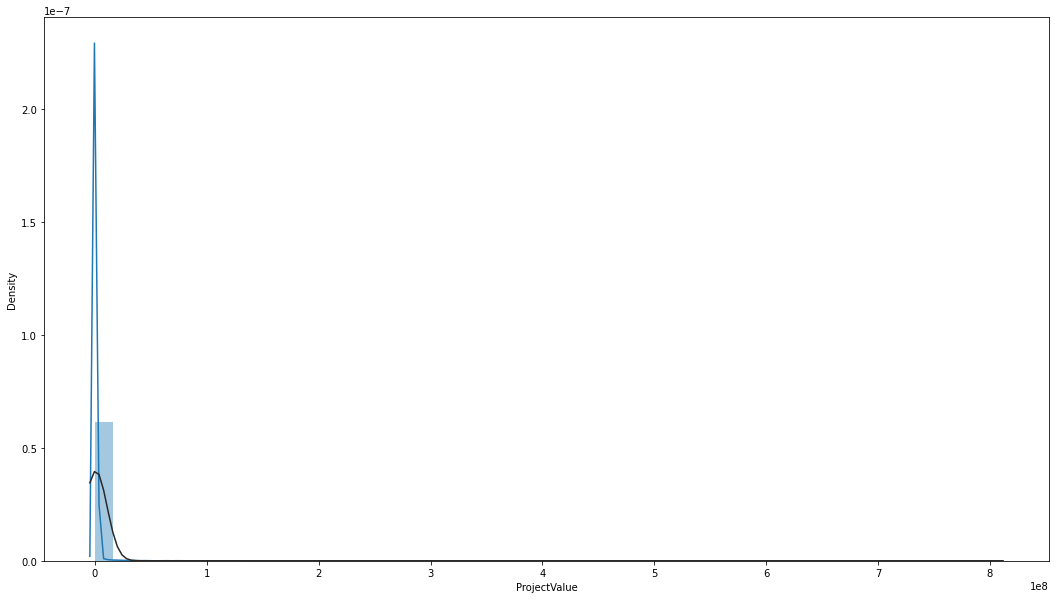

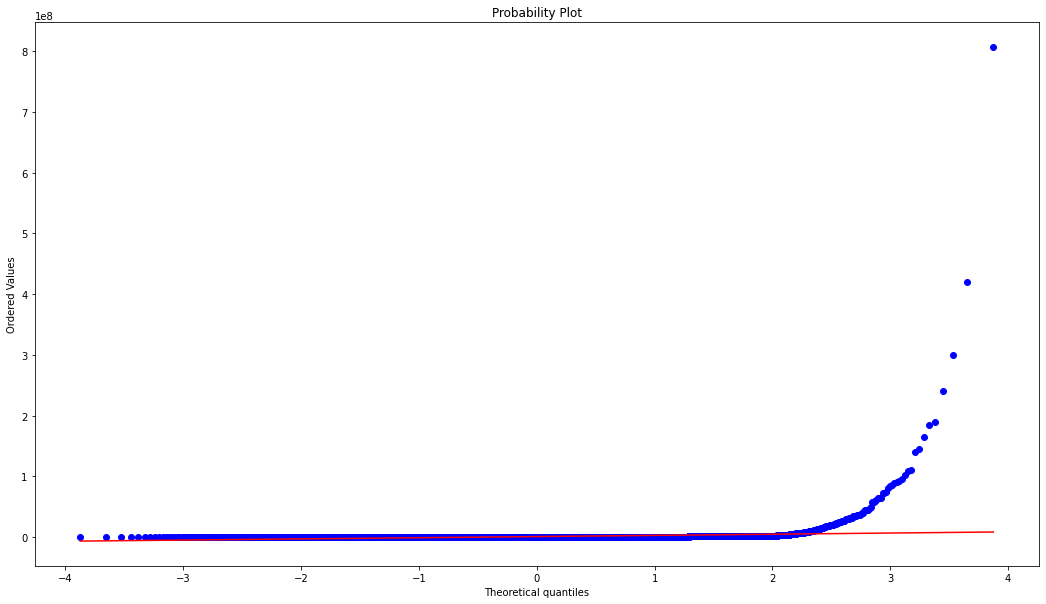

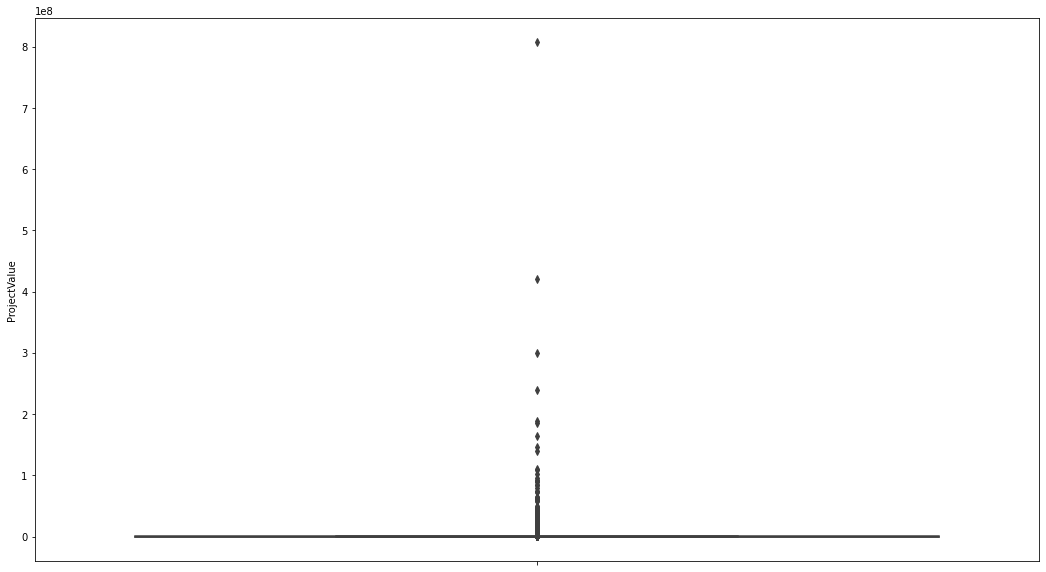

In [96]:
check_distribution(permits_df,'ProjectValue')

There are a large number of permits that have a value of zero. These will be considered errors, and thus removed from the analysis.

In [97]:
#Count how many zero values there are in project value

permits_df[permits_df.ProjectValue == 0].shape[0]

447

In [98]:
#Remove permits with 0 project value

permits_df = permits_df[permits_df.ProjectValue != 0]
permits_df[permits_df.ProjectValue == 0].shape[0]

0

Null hypothesis of normality is rejected.


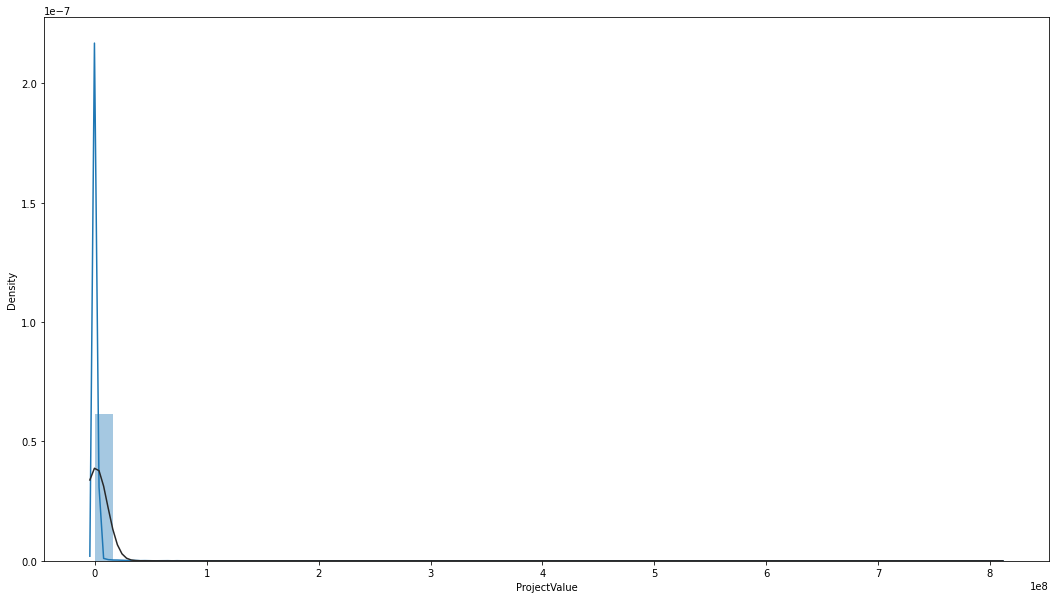

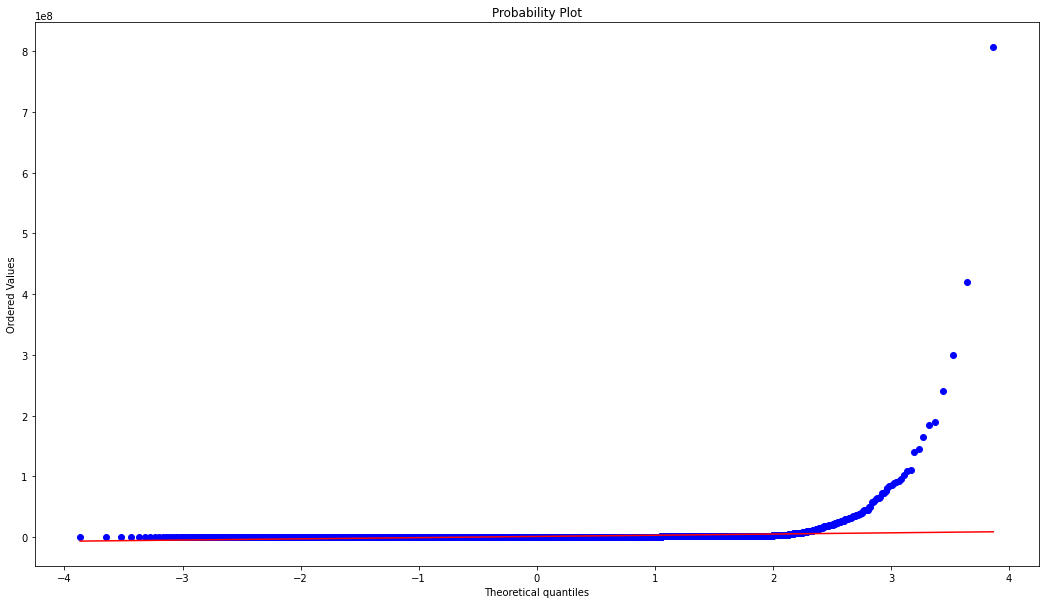

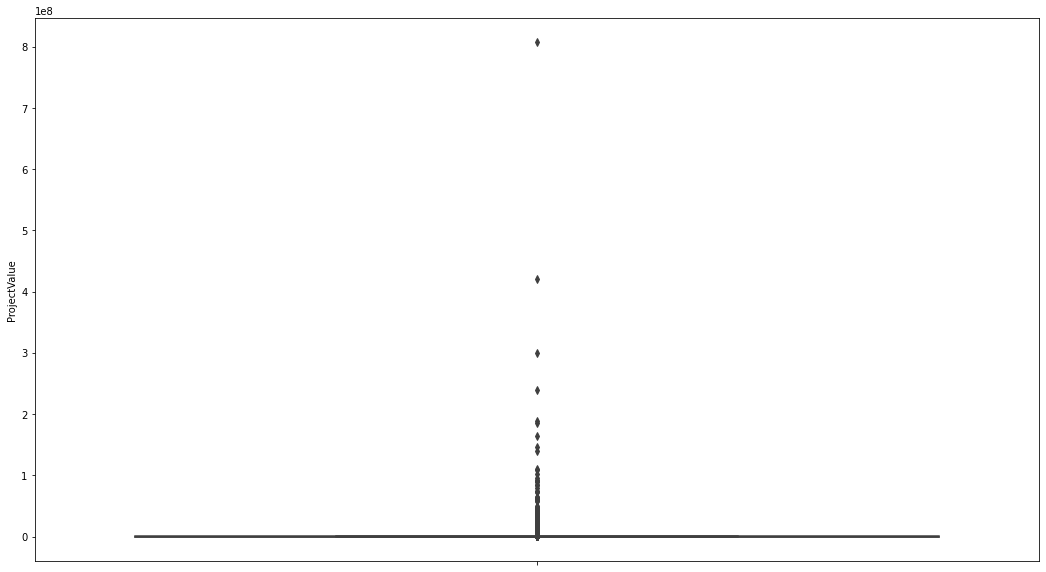

In [99]:
#Recheck the distribution after removing the permits with zero project value
check_distribution(permits_df,'ProjectValue')

In [100]:
permits_df.ProjectValue.min()

1.0

From a logical perspective, it seams unreasonable to have projects valued less than 10,000. I am going to assume permits less than 10,000 will be human error and therefore should be removed from the data set.

In [101]:
permits_df = permits_df[permits_df.ProjectValue > 10000]

Null hypothesis of normality is rejected.


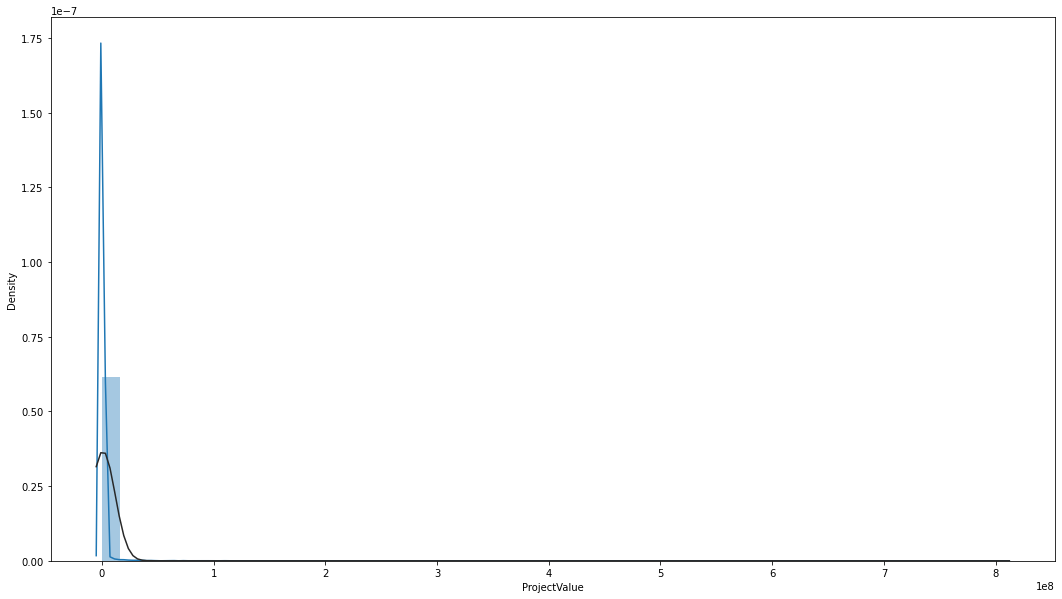

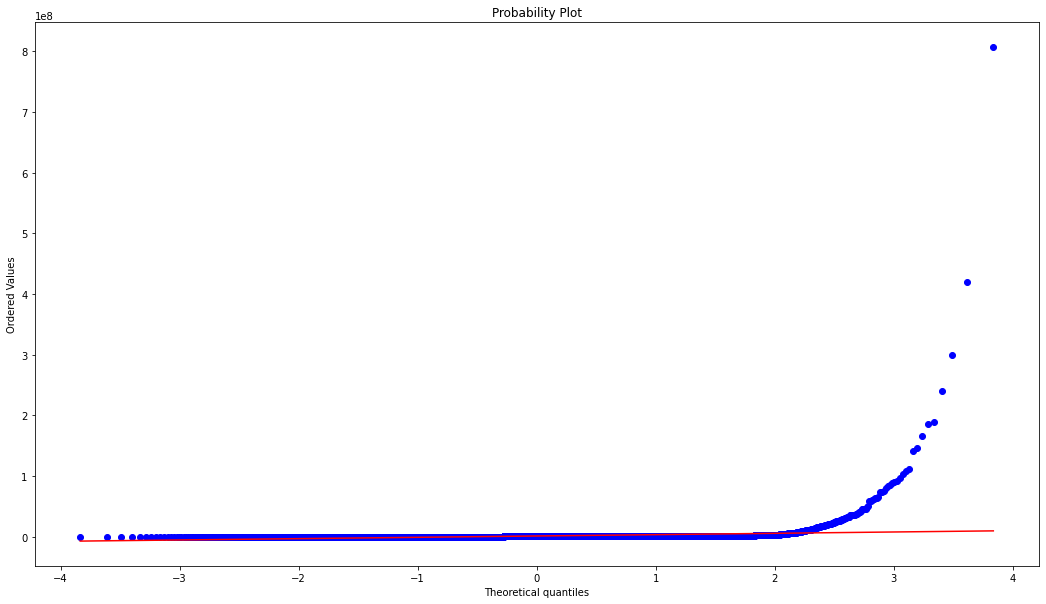

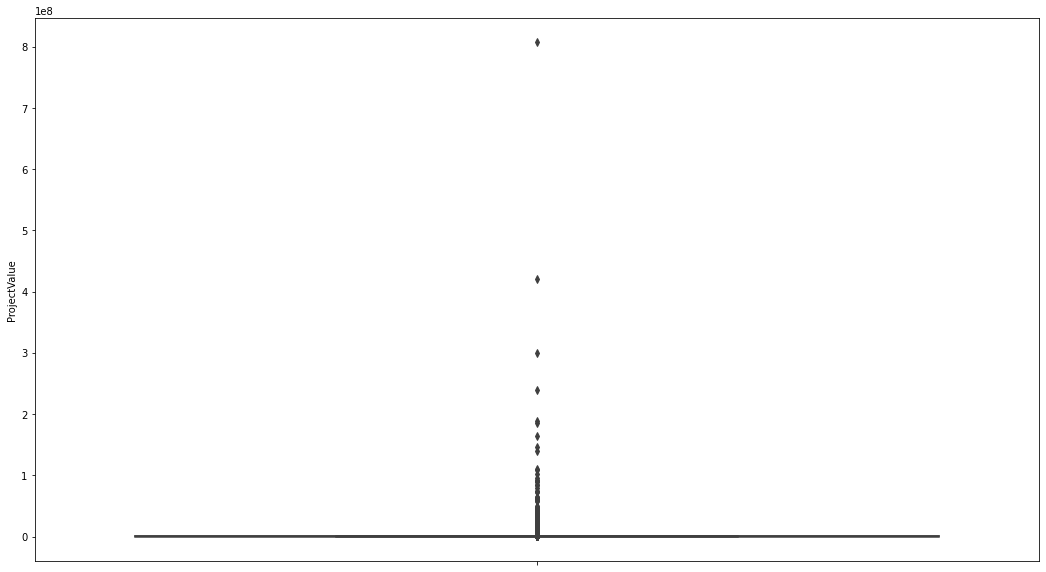

In [102]:
check_distribution(permits_df,'ProjectValue')

In [103]:
print(f"The 25th percentile value is {permits_df.ProjectValue.quantile(0.25)}")
print(f"The 50th percentile value is {permits_df.ProjectValue.quantile(0.5)}")
print(f"The 75th percentile value is {permits_df.ProjectValue.quantile(0.75)}")
print(f"The 99th percentile value is {permits_df.ProjectValue.quantile(0.99)}")

The 25th percentile value is 55000.0
The 50th percentile value is 164470.0
The 75th percentile value is 550000.0
The 99th percentile value is 12622499.999999946


There are still a very large number of outliers within the data set. Because of this I will remove values using the IQR method.

In [104]:
Q1 = permits_df.ProjectValue.quantile(0.25)
Q3 = permits_df.ProjectValue.quantile(0.75)
IQR = Q3 - Q1

lower_limit = Q1 - 1.5*IQR
upper_limit = Q3 + 1.5*IQR

permits_df = permits_df[(permits_df.ProjectValue > lower_limit)&(permits_df.ProjectValue < upper_limit)]

Null hypothesis of normality is rejected.


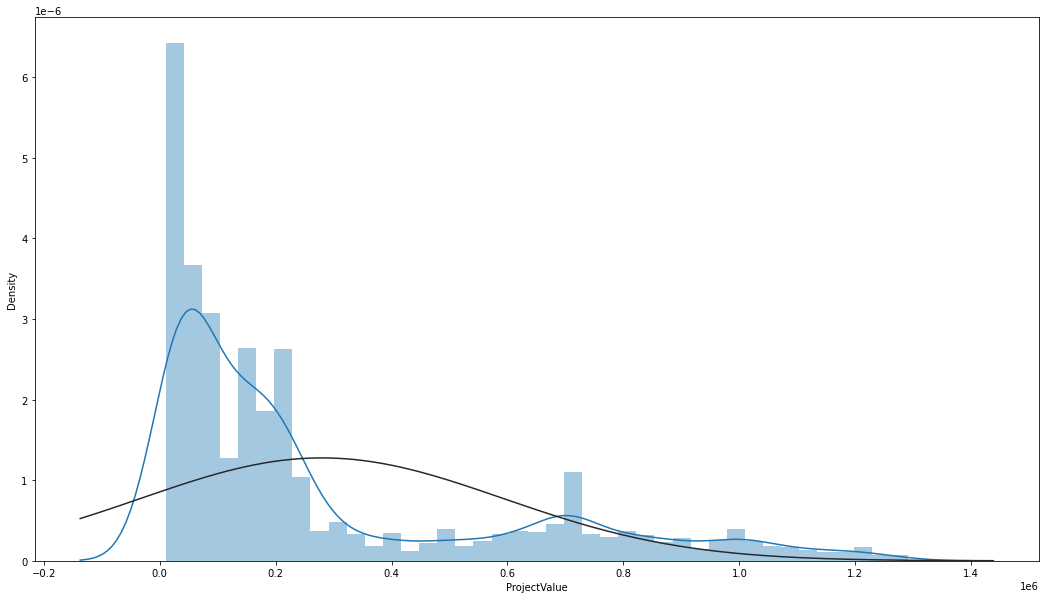

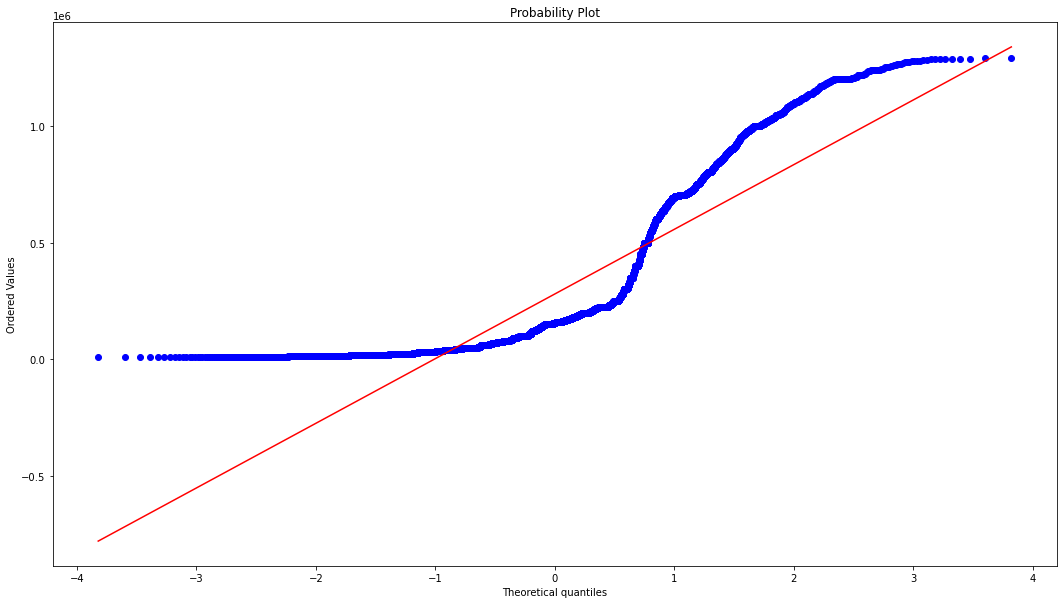

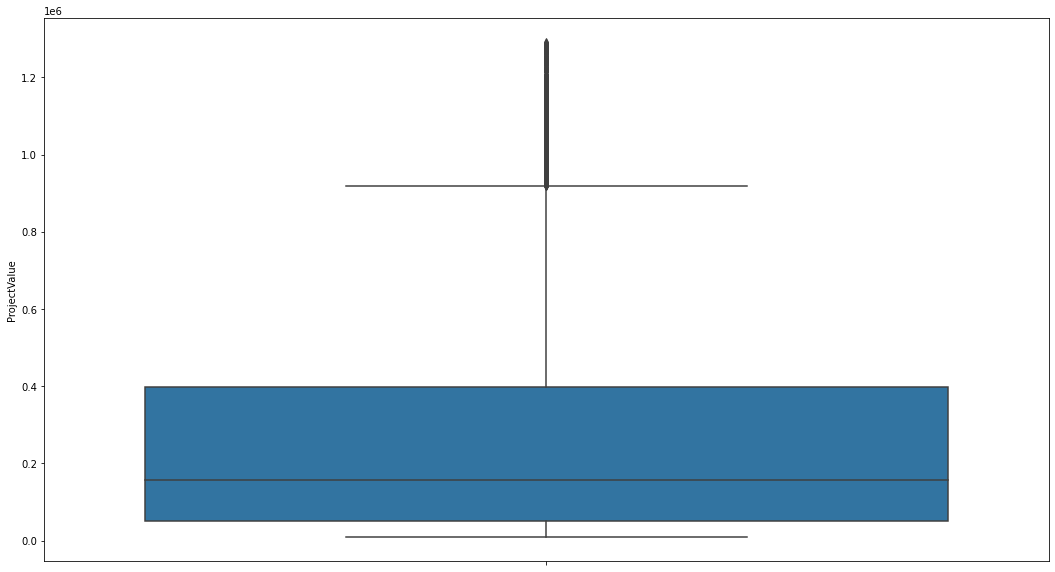

In [105]:
check_distribution(permits_df,'ProjectValue')

Project value is still not normally distributed and should be transformed. At this time I will assess the other numerical feature in the data set which is distance to nearest transit station.

In [106]:
skew_features = permits_df[['ProjectValue','DistanceToNearestTransitStation']].apply(lambda x: skew(x)).sort_values(ascending=False)
skew_features

DistanceToNearestTransitStation    1.377076
ProjectValue                       1.367430
dtype: float64

In [111]:
#Log transform the numerical features given they are highly skewed

cols_to_log = ['ProjectValue','DistanceToNearestTransitStation']

for i in cols_to_log:
    
    permits_df[i] = np.log(permits_df[i])

Null hypothesis of normality is rejected.


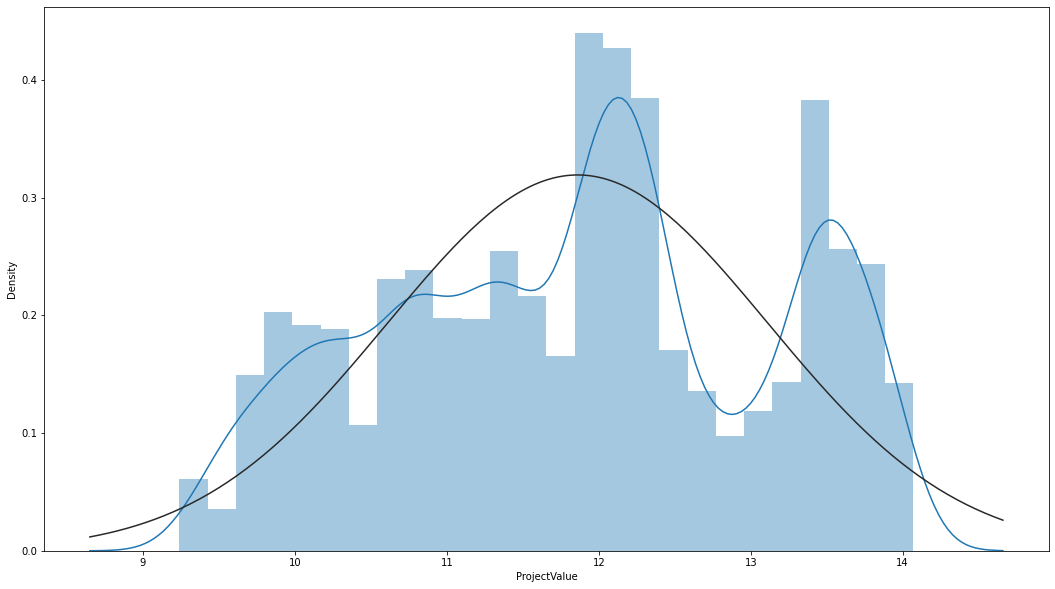

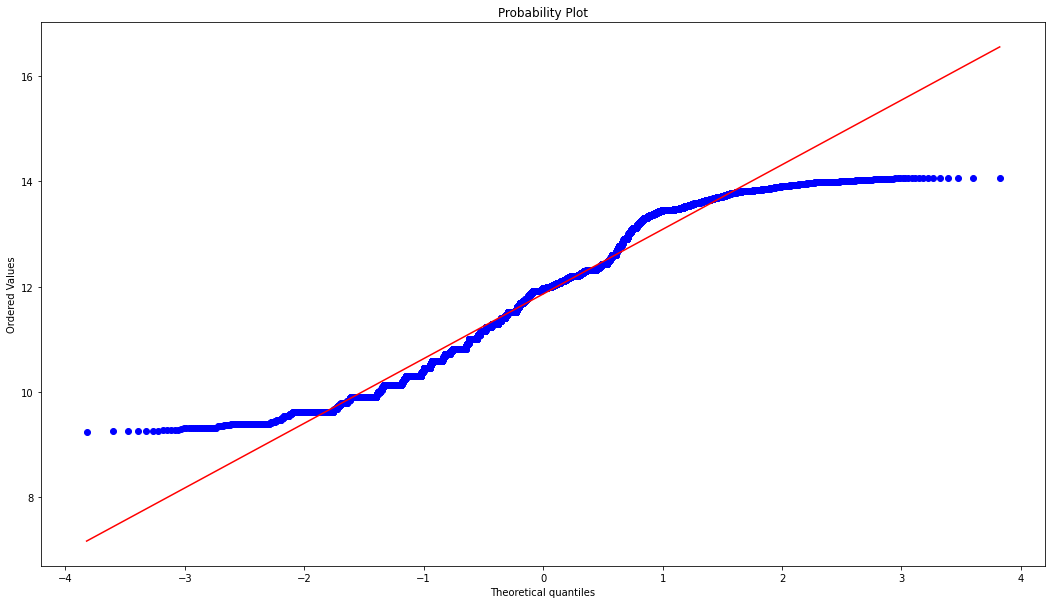

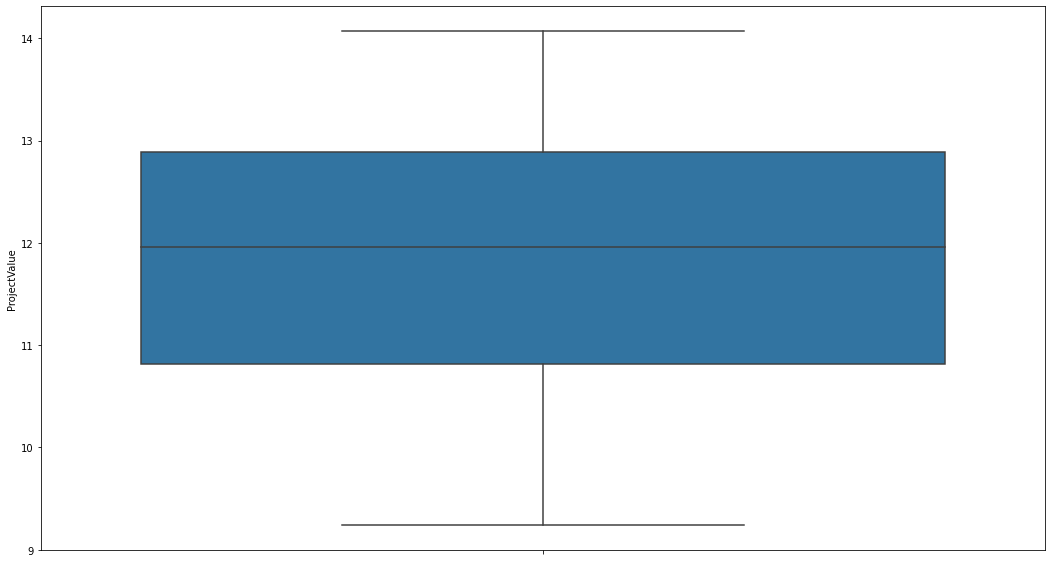

In [108]:
check_distribution(permits_df,'ProjectValue')

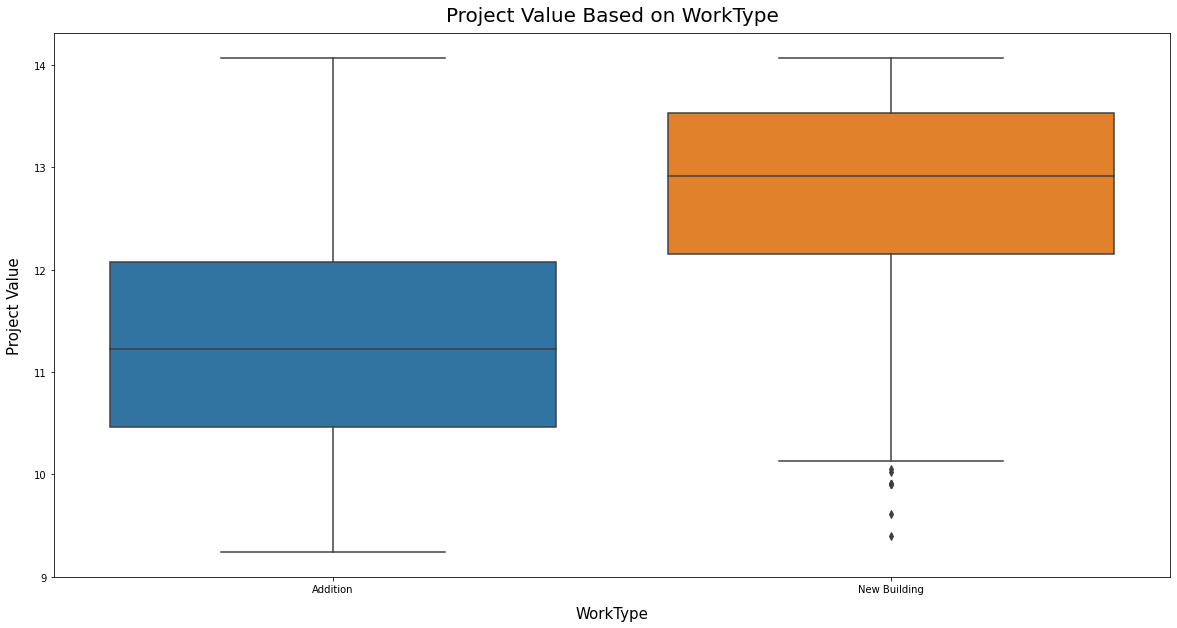

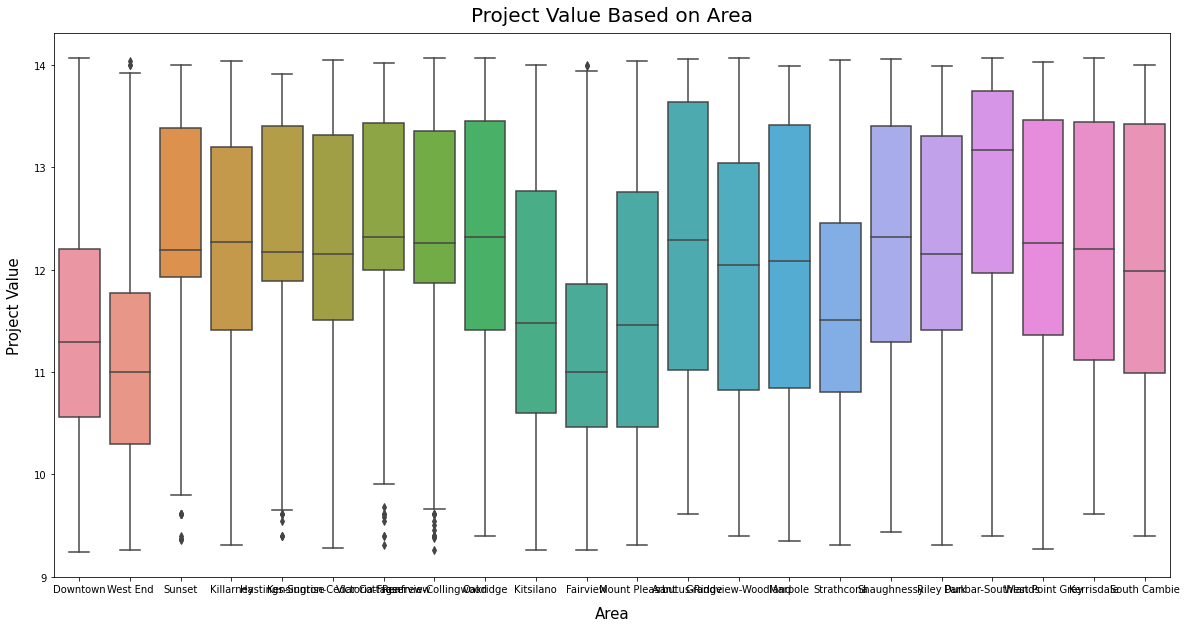

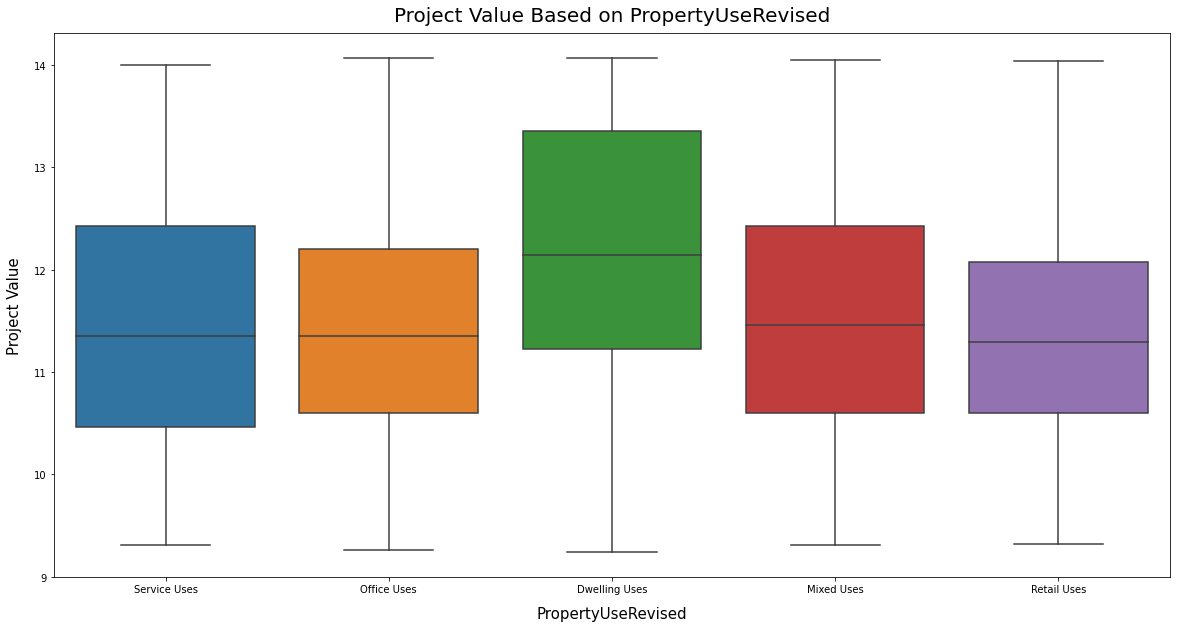

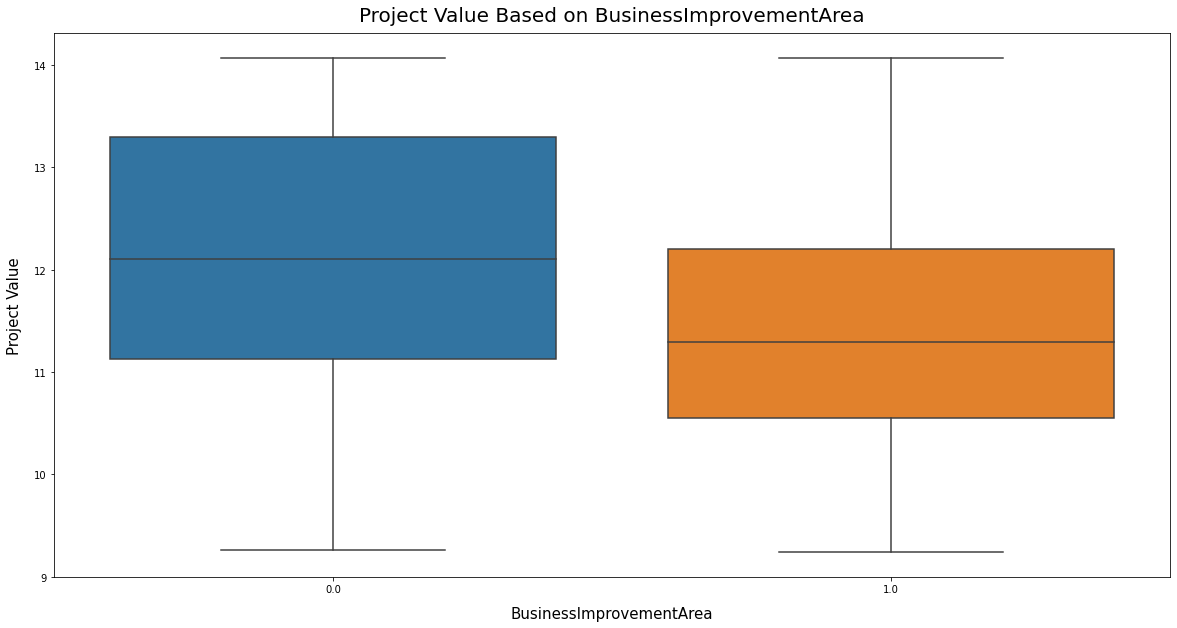

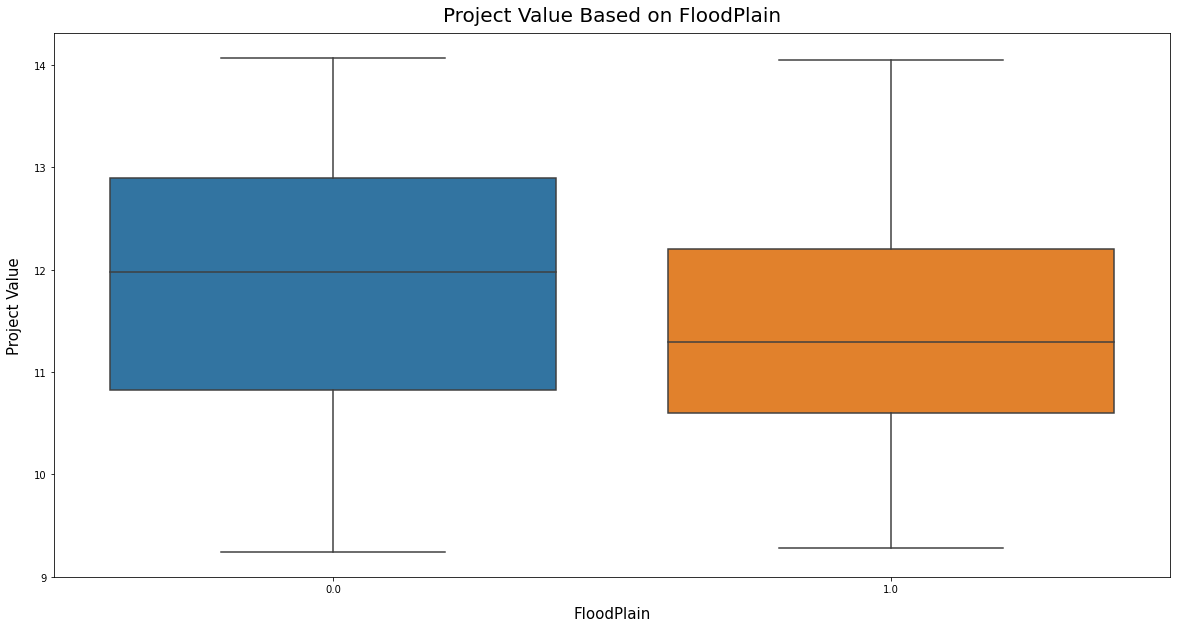

In [109]:
#Box plot for categorical features

for col in cat_cols:
    plt.figure(figsize=(20,10))
    sns.boxplot(x= col, y= 'ProjectValue', data=permits_df)
    plt.xlabel(f"{col}", fontsize= 15, labelpad =12)
    plt.ylabel("Project Value", fontsize= 15, labelpad =12)
    plt.title(f"Project Value Based on {col}", fontsize=20, pad= 12);

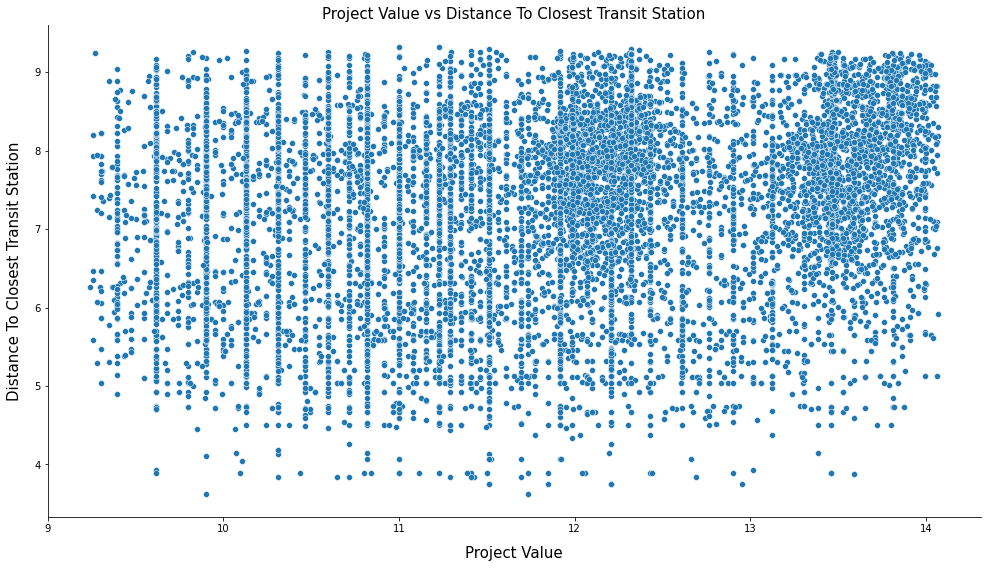

In [110]:
g = sns.relplot(x='ProjectValue', y='DistanceToNearestTransitStation', data=permits_df)
g.fig.set_size_inches(15,8)
plt.ylabel('Distance To Closest Transit Station', fontsize= 15, labelpad = 12)
plt.xlabel('Project Value', fontsize= 15, labelpad = 12)
plt.title('Project Value vs Distance To Closest Transit Station', fontsize= 15);